In [30]:
import numpy as np
import torch as th
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.io import read_image
from pathlib import Path
import cv2
import os, tqdm, sys
import re

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20, 20)   # figsize

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
        # seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

def get_shadow_diff(img1, img2, c_type='L', signed=False):
    # Compute Shadow Difference
    img1 = np.array(img1.convert(c_type)) / 255.0
    img2 = np.array(img2.convert(c_type)) / 255.0
    if signed:
        shadow_diff = img2 - img1
    else:
        shadow_diff = np.abs(img2 - img1)
    return shadow_diff

def create_image_grid(images, n_rows=1):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image

# Settings up the paths

In [31]:
# Dataset
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'train'
image_path = f'{data_path}/ffhq_256/{set_}/'
mask_path = f'{data_path}/face_segment/{set_}/anno/'
shadows_path = f'{data_path}/shadow_masks/{set_}/'

# Sampling
reshadow_path = ''
model = 'log=Masked_Face_woclip+BgNoHead+shadow_256_cfg=Masked_Face_woclip+BgNoHead+shadow_256.yaml_tomin_steps=50'
n_frames = 3
if set_ == 'train':
    sampling_path = f'/data/mint/sampling/TPAMI/FFHQ_diffuse_face/{model}/ema_085000/train_sub'
else:
    sampling_path = f'/data/mint/sampling/TPAMI/FFHQ_diffuse_face/{model}/ema_085000/{set_}'
ckpt = 'ema_085000'

def progress(vid, mothership=False):
    if mothership:
        progress_path = sampling_path
    else:
        if set_ == 'train':
            progress_path = f'/data/mint/sampling/TPAMI/FFHQ_diffuse_face/mount_sampling/v{vid}/{model}/{ckpt}/train_sub/'
        else:
            progress_path = f'/data/mint/sampling/TPAMI/FFHQ_diffuse_face/mount_sampling/v{vid}/{model}/{ckpt}/{set_}/'
    if os.path.exists(progress_path):
        print("Available: ", os.listdir(progress_path))
    else: 
        print(f"[#] No sampling on this vid={vid}!")
        return []
    
    img_path = []
    for p in sorted(os.listdir(progress_path)):
        if set_ == 'train':
            start = int(p.split('_')[1])
            end = int(p.split('_')[3])
            n = end - start
            tail = f'{progress_path}/{p}/shadow/reverse_sampling/'
        elif set_ == 'valid':
            assert p == 'shadow'
            n = 1
            tail = f'{progress_path}/shadow/reverse_sampling/'
            start = '60000'
        else: raise NotImplementedError(f"Set: {set_} is not found!")
        count = 0
        for t in sorted(os.listdir(tail)):
            tmp = f'{tail}/{t}/dst={start}.jpg/Lerp_1000/n_frames={n_frames}/'
            assert len(os.listdir(tmp)) == n_frames * 2 + 1
            count += 1
            img_path.append(tmp)
            
        print(f'[#] {p} => {count}/{n} => {count * 100/n:.2f}%')
    return img_path
            
        
img_path = progress(vid='11')

Available:  ['train_50000_to_55000', 'train_55000_to_60000']
[#] train_50000_to_55000 => 5000/5000 => 100.00%
[#] train_55000_to_60000 => 5000/5000 => 100.00%


[#] Image name:  52205


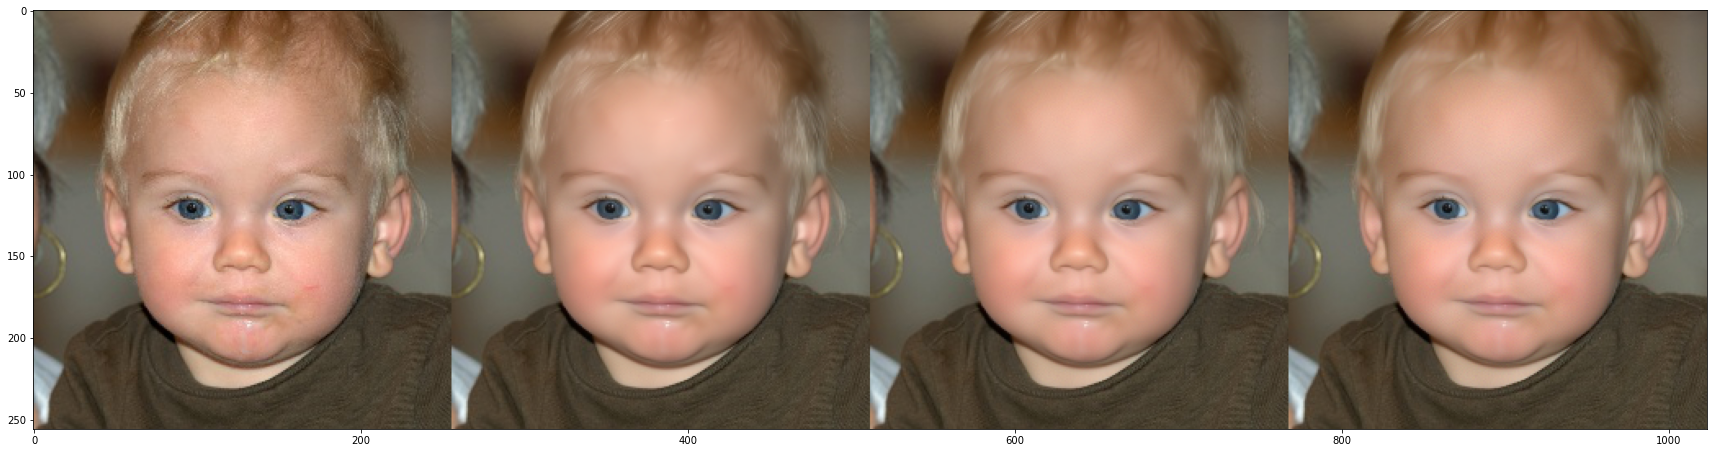

[#] Shadow difference: 


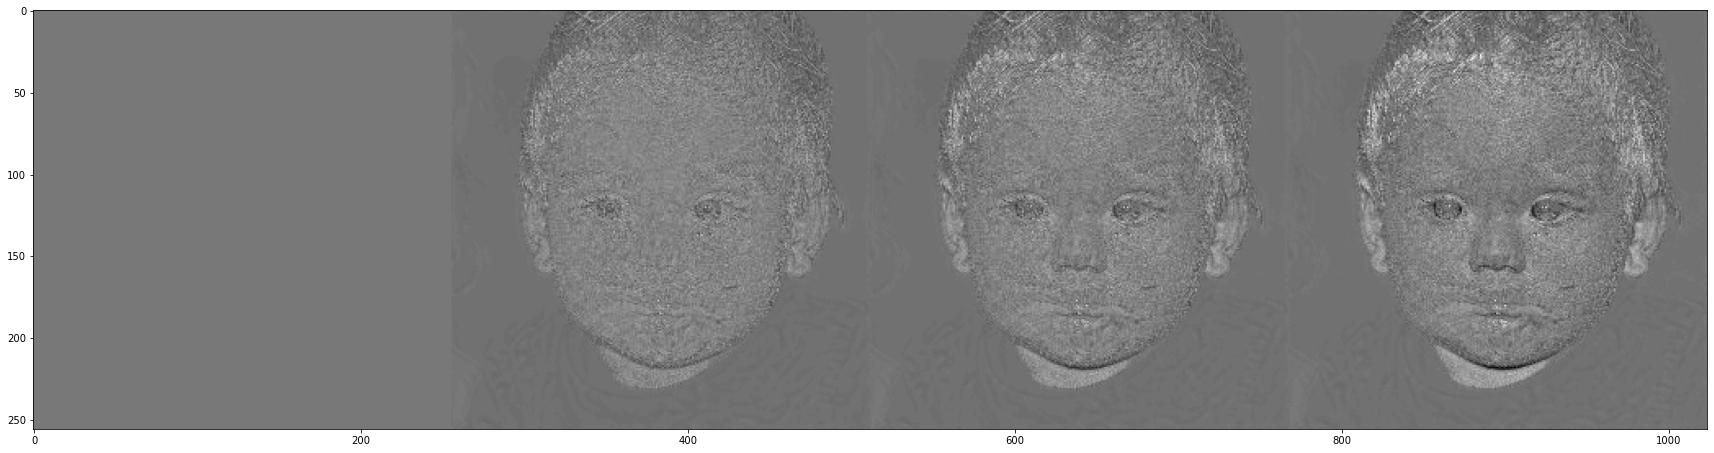

[#] Thresholding the shadow difference: 


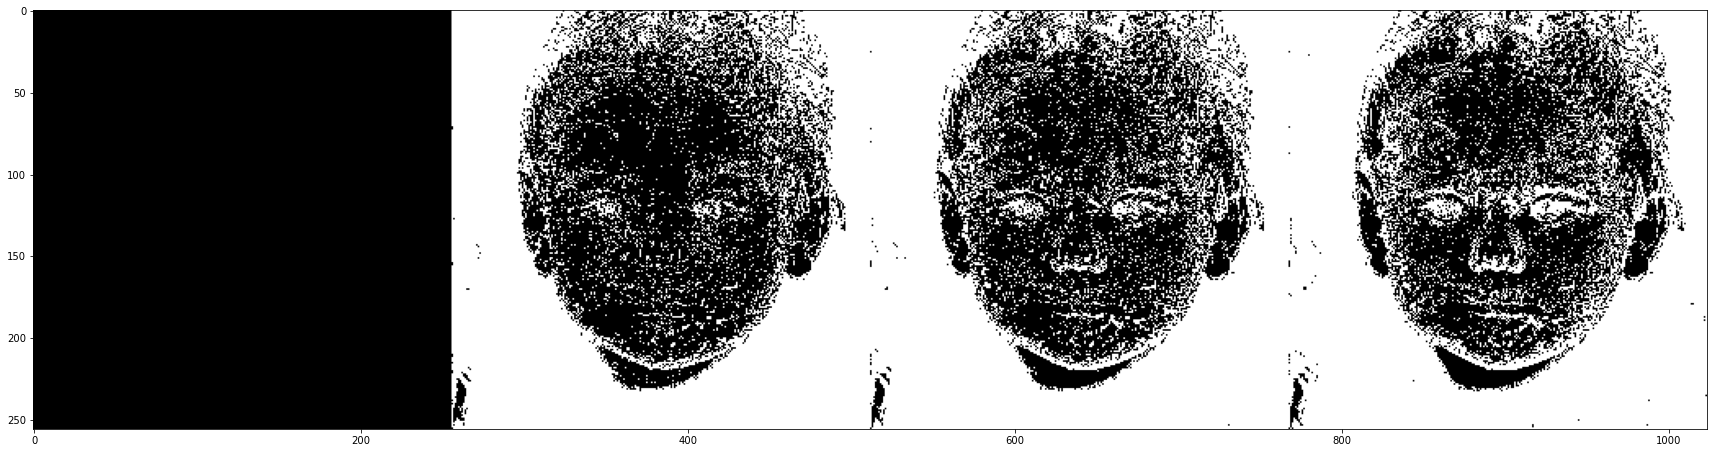

[#] Preprocessing the shadow difference: 


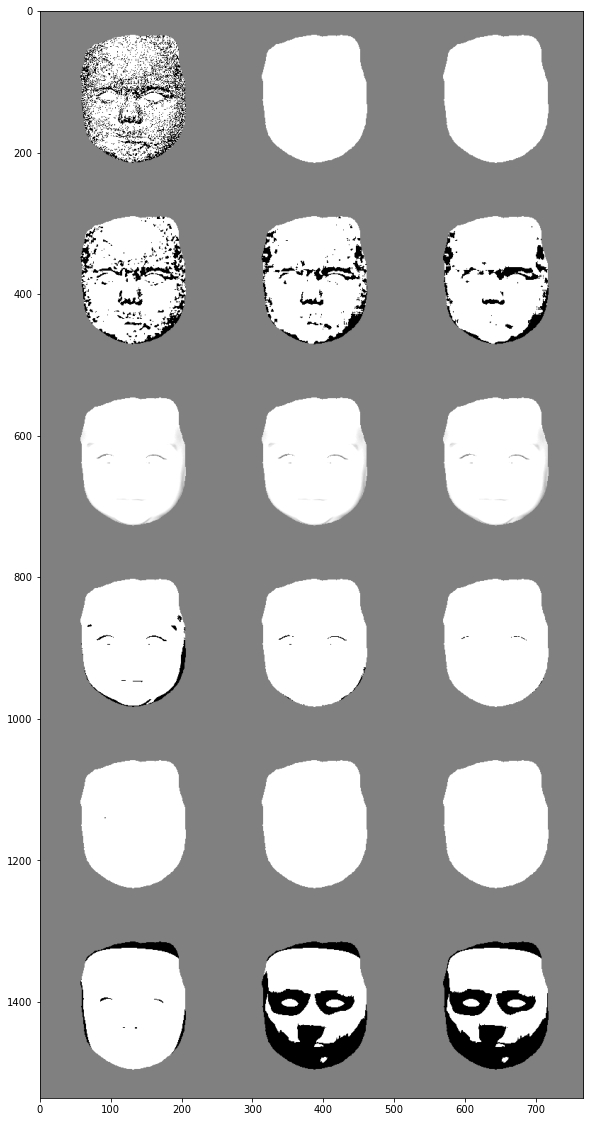

In [32]:
idx = 2205
img_name = re.findall(r"src=\d+\.jpg", img_path[idx])[0].split('=')[1].split('.')[0]
print("[#] Image name: ", img_name)
face_image = Image.open(f'{image_path}/{img_name}.jpg')
mask_image = Image.open(f'{mask_path}/anno_{img_name}.png')
m_face = face_segment('faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses', mask_image)
m_glasses_and_eyes = face_segment('faceseg_eyes&glasses', mask_image)
cast_shadows = Image.open(f'{shadows_path}/{img_name}.png')
reshadow_img = [face_image] + [Image.open(f'{img_path[idx]}/res_frame{f}.png') for f in range(n_frames)]
plt.figure(figsize=(30, 30))
plt.imshow(create_image_grid(reshadow_img, 1), cmap='gray')
plt.show()

c_type = 'L'
out = []
for i in range(len(reshadow_img)):
    out.append(get_shadow_diff(img1=reshadow_img[i], img2=reshadow_img[0], c_type=c_type, signed=True))

print("[#] Shadow difference: ")
plt.figure(figsize=(30, 30))
plt.imshow(create_image_grid(out, 1), cmap='gray')
plt.show()
    
print("[#] Thresholding the shadow difference: ")
plt.figure(figsize=(30, 30))
plt.imshow(create_image_grid(out, 1) < 0, cmap='gray')
plt.show()

print("[#] Preprocessing the shadow difference: ")
# thres = -0.05
thres = 0
inp_face = (np.array(face_image.convert(c_type))/255.0).astype(np.float32)
cast_shadows = np.array(cast_shadows) / 255.0
assert np.all(cast_shadows[..., 0] == cast_shadows[..., 1])
assert np.all(cast_shadows[..., 0] == cast_shadows[..., 2])
tmp = [
    (out[-1] < thres).astype(np.float32),
    (out[-1] < -0.1).astype(np.float32),
    (out[-1] < -0.2).astype(np.float32),
    
    cv2.medianBlur(((out[-1] < thres).astype(np.uint8)), 3),
    cv2.medianBlur(((out[-1] < thres).astype(np.uint8)), 5),
    cv2.medianBlur(((out[-1] < thres).astype(np.uint8)), 7),
    
    np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0).astype(np.float32),
    np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0).astype(np.float32),
    np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0).astype(np.float32),
    
    (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.1).astype(np.float32),
    (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.3).astype(np.float32),
    (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.5).astype(np.float32),
                                                                             
    (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.7).astype(np.float32),
    (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.8).astype(np.float32),
    (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.9).astype(np.float32),
    
    (cast_shadows[..., 0] < 0.3).astype(np.float32),
    (cast_shadows[..., 0] < 0.5).astype(np.float32),
    (cast_shadows[..., 0] < 0.7).astype(np.float32),
]
# plt.figure(figsize=(15, 15))
# tmp = [(np.abs(1 - (t)) * m_face) for t in tmp] # Invert the mask
# plt.imshow(create_image_grid(tmp, 2), cmap='gray')
# plt.show()
# tmp = [np.abs(1 - (t)) for t in tmp] # Invert the mask
# tmp = [(((t * ~m_glasses_and_eyes) + (1.0 * m_glasses_and_eyes)) * m_face) + (0.5 * ~m_face)  for t in tmp] # Ensure glasses area always 1
# plt.figure(figsize=(15, 15))
# for t in tmp:
#     print(t.shape)
#     print(np.max(t), np.min(t))
tmp = [np.abs(1 - (t)) for t in tmp] # Invert the mask
tmp = [((t * ~m_glasses_and_eyes) + (1.0 * m_glasses_and_eyes))  for t in tmp] # Ensure glasses area always 1
tmp = [((t * m_face) + (0.5 * ~m_face)) for t in tmp] # Ensure outer face area always 0.5
plt.imshow(create_image_grid(tmp, 6), cmap='gray')
plt.show()

# Process each images

In [33]:
diffuse_img_path = progress(vid='11') + progress(vid='10', mothership=True) + progress(vid='9') + progress(vid='8')
print("[#] Total images: ", len(diffuse_img_path))

Available:  ['train_50000_to_55000', 'train_55000_to_60000']
[#] train_50000_to_55000 => 5000/5000 => 100.00%
[#] train_55000_to_60000 => 5000/5000 => 100.00%
Available:  ['train_0_to_5000', 'train_5000_to_10000', 'train_10000_to_15000']
[#] train_0_to_5000 => 5000/5000 => 100.00%
[#] train_10000_to_15000 => 5000/5000 => 100.00%
[#] train_5000_to_10000 => 5000/5000 => 100.00%
Available:  ['train_20000_to_25000', 'train_25000_to_30000', 'train_30000_to_35000', 'train_15000_to_20000']
[#] train_15000_to_20000 => 5000/5000 => 100.00%
[#] train_20000_to_25000 => 5000/5000 => 100.00%
[#] train_25000_to_30000 => 5000/5000 => 100.00%
[#] train_30000_to_35000 => 5000/5000 => 100.00%
Available:  ['train_35000_to_40000', 'train_45000_to_50000', 'train_40000_to_45000']
[#] train_35000_to_40000 => 5000/5000 => 100.00%
[#] train_40000_to_45000 => 5000/5000 => 100.00%
[#] train_45000_to_50000 => 5000/5000 => 100.00%
[#] Total images:  60000


In [ ]:
def save_shadow_diff(plot=False):
    # for idx, path in tqdm.tqdm(enumerate(diffuse_img_path)):
    count = 0
    for path in tqdm.tqdm(diffuse_img_path):
        
        out_path = [f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/thres_5e-2/{set_}/',
                    f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/thres_1e-1/{set_}/',
                    f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/median5_5e-2/{set_}/',
                ]
        
        img_name = re.findall(r"src=\d+\.jpg", path)[0].split('=')[1].split('.')[0]
        if os.path.exists(f'{out_path[0]}/{img_name}.png') and os.path.exists(f'{out_path[1]}/{img_name}.png') and os.path.exists(f'{out_path[2]}/{img_name}.png'):
            continue
        face_image = Image.open(f'{image_path}/{img_name}.jpg')
        mask_image = Image.open(f'{mask_path}/anno_{img_name}.png')
        m_face = face_segment('faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses', mask_image)
        m_glasses_and_eyes = face_segment('faceseg_eyes&glasses', mask_image)
        reshadow_img = [face_image] + [Image.open(f'{path}/res_frame{f}.png') for f in range(n_frames)]
        c_type = 'L'
        out = []
        for i in range(len(reshadow_img)):
            out.append(get_shadow_diff(img1=reshadow_img[i], img2=reshadow_img[0], c_type=c_type, signed=True))
        
        thres = -0.05
        tmp = [
            out[-1] < thres,
            out[-1] < -0.1,
            out[-1] < -0.2,
            cv2.medianBlur(((out[-1] < thres).astype(np.uint8)), 3),
            cv2.medianBlur(((out[-1] < thres).astype(np.uint8)), 5),
            cv2.medianBlur(((out[-1] < thres).astype(np.uint8)), 7),
            
        ]
        
        tmp = [np.abs(1 - (t)) for t in tmp] # Invert the mask
        tmp = [((t * ~m_glasses_and_eyes) + (1.0 * m_glasses_and_eyes))  for t in tmp] # Ensure glasses area always 1
        tmp = [((t * m_face) + (0.5 * ~m_face)) for t in tmp] # Ensure outer face area always 0.5
        
        if plot:
            plt.figure(figsize=(30, 30))
            plt.imshow(create_image_grid(reshadow_img, 1), cmap='gray')
            plt.show()
            plt.figure(figsize=(15, 15))
            plt.imshow(create_image_grid(tmp, 2), cmap='gray')
            plt.show()
            
        out_img = [tmp[0], tmp[1], tmp[4]]
        for op, oi in zip(out_path, out_img):
            if not os.path.exists(op):
                os.makedirs(op)
            # np.save(f'{op}/{img_name}.npy', oi)
            Image.fromarray((oi * 255).astype(np.uint8)).save(f'{op}/{img_name}.png')
            
        count += 1
        if plot:
            if count > 5: assert False
save_shadow_diff(plot=False)

In [ ]:
def save_shadow_futschik(plot=False):
    # for idx, path in tqdm.tqdm(enumerate(diffuse_img_path)):
    count = 0
    for path in tqdm.tqdm(diffuse_img_path):
        
        out_path = [f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/futschik/{set_}/',
                    f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/futschik_1e-1/{set_}/',
                    f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/futschik_2e-1/{set_}/',
        ]
        
        img_name = re.findall(r"src=\d+\.jpg", path)[0].split('=')[1].split('.')[0]
        if os.path.exists(f'{out_path[0]}/{img_name}.png') and os.path.exists(f'{out_path[1]}/{img_name}.png') and os.path.exists(f'{out_path[2]}/{img_name}.png'):
            continue
        face_image = Image.open(f'{image_path}/{img_name}.jpg')
        mask_image = Image.open(f'{mask_path}/anno_{img_name}.png')
        m_face = face_segment('faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses', mask_image)
        m_glasses_and_eyes = face_segment('faceseg_eyes&glasses', mask_image)
        reshadow_img = [face_image] + [Image.open(f'{path}/res_frame{f}.png') for f in range(n_frames)]
        c_type = 'L'
        out = []
        for i in range(len(reshadow_img)):
            out.append(get_shadow_diff(img1=reshadow_img[i], img2=reshadow_img[0], c_type=c_type, signed=True))
        
        inp_face = (np.array(face_image.convert(c_type))/255.0).astype(np.float32)
        thres = -0.05
        tmp = [
            out[-1] < thres,
            out[-1] < -0.1,
            out[-1] < -0.2,
            np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0),
            np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.0,
            np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.1,
            
            (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.2),
            (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.3),
            (np.maximum(np.minimum(1 - (inp_face)/(out[-1]+0.5 + 1e-8), 1), 0) > 0.5),
        ]
        
        tmp = [np.abs(1 - (t)) for t in tmp] # Invert the mask
        tmp = [((t * ~m_glasses_and_eyes) + (1.0 * m_glasses_and_eyes))  for t in tmp] # Ensure glasses area always 1
        tmp = [((t * m_face) + (0.5 * ~m_face)) for t in tmp] # Ensure outer face area always 0.5
        
        if plot:
            plt.figure(figsize=(30, 30))
            plt.imshow(create_image_grid(reshadow_img, 1), cmap='gray')
            plt.show()
            plt.figure(figsize=(15, 15))
            plt.imshow(create_image_grid(tmp, 3), cmap='gray')
            plt.show()
            
        out_img = [tmp[3], tmp[5], tmp[6]]
        for op, oi in zip(out_path, out_img):
            if not os.path.exists(op):
                os.makedirs(op)
            # np.save(f'{op}/{img_name}.npy', oi)
            Image.fromarray((oi * 255).astype(np.uint8)).save(f'{op}/{img_name}.png')
            
        count += 1
        # if count > 10: assert False
save_shadow_futschik(plot=False)

# FOR CREATING A VISUAL COMPARISON

In [34]:
def save_shadow_mask(plot=False):
    # for idx, path in tqdm.tqdm(enumerate(diffuse_img_path)):
    count = 0
    for path in tqdm.tqdm(diffuse_img_path):
        
        out_path = [f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_masks_t5e-2_forvis/{set_}/',]
        
        img_name = re.findall(r"src=\d+\.jpg", path)[0].split('=')[1].split('.')[0]
        if os.path.exists(f'{out_path[0]}/{img_name}.png'):
            continue
        face_image = Image.open(f'{image_path}/{img_name}.jpg')
        mask_image = Image.open(f'{mask_path}/anno_{img_name}.png')
        m_face = face_segment('faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses', mask_image)
        m_glasses_and_eyes = face_segment('faceseg_eyes&glasses', mask_image)
        cast_shadows = Image.open(f'{shadows_path}/{img_name}.png')
        cast_shadows = np.array(cast_shadows) / 255.0
        assert np.all(cast_shadows[..., 0] == cast_shadows[..., 1])
        assert np.all(cast_shadows[..., 0] == cast_shadows[..., 2])
        reshadow_img = [face_image] + [Image.open(f'{path}/res_frame{f}.png') for f in range(n_frames)]
        c_type = 'L'
        out = []
        for i in range(len(reshadow_img)):
            out.append(get_shadow_diff(img1=reshadow_img[i], img2=reshadow_img[0], c_type=c_type, signed=True))
        
        thres = -0.05
        tmp = [
            (cast_shadows[..., 0] < 0.5).astype(np.float32),
            
        ]
        
        tmp = [np.abs(1 - (t)) for t in tmp] # Invert the mask
        tmp = [((t * ~m_glasses_and_eyes) + (1.0 * m_glasses_and_eyes))  for t in tmp] # Ensure glasses area always 1
        tmp = [((t * m_face) + (0.5 * ~m_face)) for t in tmp] # Ensure outer face area always 0.5
        
        if plot:
            plt.figure(figsize=(30, 30))
            plt.imshow(create_image_grid(reshadow_img, 1), cmap='gray')
            plt.show()
            plt.figure(figsize=(15, 15))
            plt.imshow(create_image_grid(tmp, 2), cmap='gray')
            plt.show()
            
        out_img = [tmp[0]]
        for op, oi in zip(out_path, out_img):
            if not os.path.exists(op):
                os.makedirs(op)
            # np.save(f'{op}/{img_name}.npy', oi)
            Image.fromarray(np.clip((oi * 255).astype(np.uint8), 0, 255)).save(f'{op}/{img_name}.png')
            
        count += 1
        if plot:
            if count > 5: assert False
save_shadow_mask(plot=False)

100%|██████████| 60000/60000 [1:19:42<00:00, 12.55it/s]
